In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
# python implement of RTM on Marmousi model.
# very time-consuming.

In [2]:
# I/O for marmousi model
model= np.load('marmousi.npy')

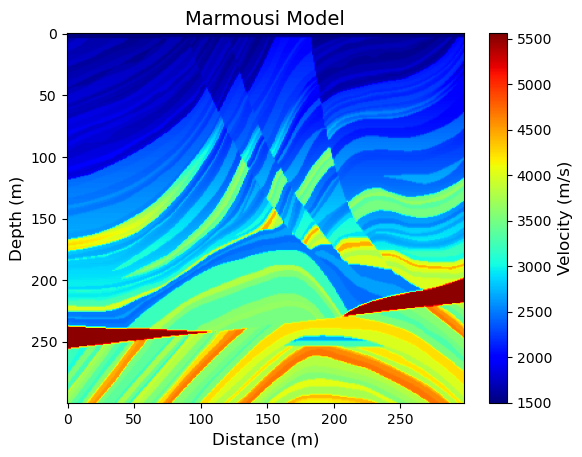

In [3]:
nz,nx = 300,298
dz,dx = 5.0,5.0
oz,ox = 0.0,0.0
z = np.linspace(0,(nz-1)*dz,nz)
x = np.linspace(0,(nx-1)*dx,nx)
Lz, Lx = nz * dz, nx * dx

plt.figure()
plt.imshow(model,cmap="jet", aspect='auto')
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
plt.title('Marmousi Model',fontsize=14)
cb = plt.colorbar()
cb.set_label('Velocity (m/s)',fontsize=12)

plt.show()

In [4]:
from pdesolver.hyperbolic_hetero import awe_2d_explicit_solver_heterogeneous_8th_order, awe_2d_heterogeneous_8th_order_data_time_reverse
## . . Init wavefields on spatial grid
UUo = np.zeros((nx,nz))
UUm = np.zeros((nx,nz))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 5000                    # . . Number of time steps, the nt should be large enough to make the wave propagate to the bottom of model
dt = CC*dx/np.max(model)         # . . Define dt based on Courant
t  = np.linspace(0, (nt - 1)*dt, nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift
v = model
## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))
shot_num = 32
sx = np.linspace(0, nx * dx, shot_num + 2)[1:-1]
sz = 25 # depth of observation

In [5]:
from tqdm.notebook import tqdm
img = np.zeros((nx, nz))
for iter in tqdm(range(shot_num)):
    fff = np.zeros((nx, nz, nt))
    for it in range(nt):
        tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dz,dt,v.T,F,it,sx[iter],sz) #calc solution at n+1
        fff[:,:,it] = tmp
        UUm = UUo
        UUo = tmp

    UUo = np.zeros((nx,nz))
    UUm = np.zeros((nx,nz))
    
    CC = 0.5
    dt = CC*dx/np.max(v) 
    t = np.linspace(0, nt * dt, nt)
    t0 = 0.05
    
    # define the forcing function
    ss = 0.01
    data = fff[:,5,:]
    ry = 25
    
    mmm = np.zeros((nx, nz, nt))
    
    # loop over function
    for it in range(nt-1, 0, -1): 
        tmp = awe_2d_heterogeneous_8th_order_data_time_reverse(UUo,UUm,dx,dz,dt,v.T,data,it,ry)
        mmm[:,:,nt-1-it]=tmp
        UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
        UUo=tmp          ## move solution at n+1 to n to prepare for next iteration
    
    img += np.sum(fff * mmm[:,:,::-1], axis = 2)

  0%|          | 0/32 [00:00<?, ?it/s]

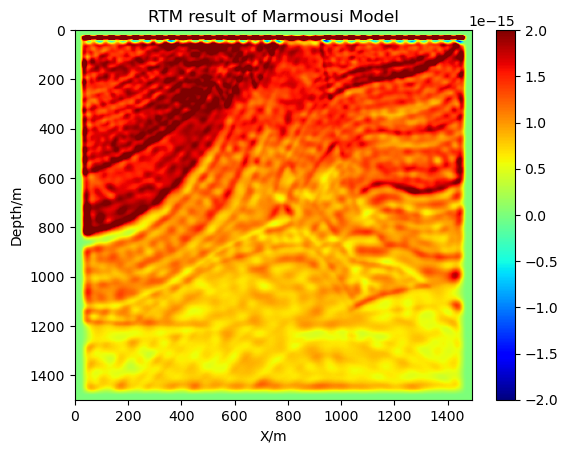

In [11]:
cx = np.array([-1,1])
plt.imshow(img.T, aspect='auto',cmap='jet',extent=[0,Lx,Lz,0])
plt.clim(cx * 2e-15)
plt.title("RTM result of Marmousi Model(nt = 5000)")
plt.xlabel("X/m")
plt.ylabel("Depth/m")
plt.colorbar()
plt.savefig("RTM_marmousi.png")
plt.show()